In [15]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
# Check if Cuda is available, training takes ~15 Minutes with Cuda, no idea how long it would take with CPU
torch.cuda.is_available()

True

In [ ]:
# Some Helper Methods

# Image Preprocess Method
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")

    # Define preprocessing transformations
    preprocess = transforms.Compose([
        transforms.Resize((244, 244)),  # Resize to 244x244
        transforms.ToTensor(),          # Convert to tensor (scales to [0, 1])
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet50
    ])

    img_tensor = preprocess(img)  # Apply transformations
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    return img_tensor


# Define DataLoader
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)  # Stack images into a batch tensor
    labels = torch.stack(labels)  # Stack labels into a batch tensor
    return images, labels

# Load images and labels into batches
def load_data(image_paths, labels, batch_size):
    data_loader = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        
        batch_images = []
        for path in batch_paths:
            image = preprocess_image(path)  # Apply the preprocessing
            batch_images.append(image)
        
        batch_labels = torch.tensor(batch_labels)  # Convert labels to tensor
        data_loader.append((torch.stack(batch_images), batch_labels))
    
    return data_loader


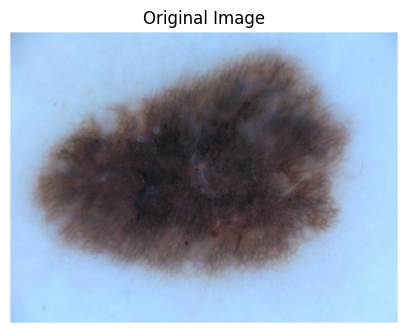

In [6]:
# Original Example Image

image_path = r"archive\ISIC_2019_Training_Input\ISIC_0000000.jpg"

# Open and display the original image
img = Image.open(image_path).convert("RGB")
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()

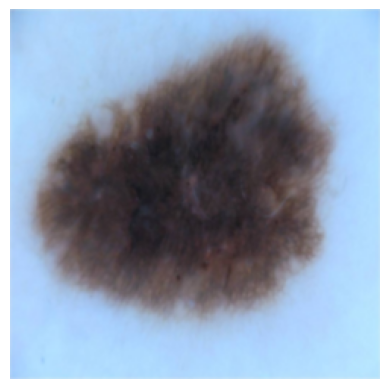

In [7]:
# Preprocessed Example Image

image_path = r"archive\ISIC_2019_Training_Input\ISIC_0000000.jpg"
img_tensor = preprocess_image(image_path)


def show_image(tensor):
    # Remove batch dimension
    img = tensor.squeeze(0)

    # Reverse normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean  # Unnormalize

    # Convert to NumPy and transpose channels
    img = img.numpy().transpose(1, 2, 0)

    # Display image
    plt.imshow(img)
    plt.axis("off")  # Hide axes
    plt.show()

show_image(img_tensor)

In [8]:
csv_file = 'archive/ISIC_2019_Training_GroundTruth.csv'
data = pd.read_csv(csv_file)

# Find Paths to each image
image_paths = [os.path.join('archive/ISIC_2019_Training_Input', f'{img_id}.jpg') for img_id in data.iloc[:, 0]]

# All columns except the first one, which is the image name
labels = data.iloc[:, 1:].values.astype('float32')  

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [9]:
# Define the batch size and DataLoader
batch_size = 32
dataset_size = len(image_paths)

In [10]:
# Load training and testing data
train_loader = load_data(train_image_paths, train_labels, batch_size)
test_loader = load_data(test_image_paths, test_labels, batch_size)

In [11]:
# Load pre-trained ResNet50
model = models.resnet50(pretrained=True)

# Modify the final layer for multi-label classification (9 classes)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 9)  # 7 output classes (MEL, NV, BCC, etc.)
)

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

c:\Users\nathh\OneDrive\Dokumente\GitHub\DSHEAL-SkinModel\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nathh\OneDrive\Dokumente\GitHub\DSHEAL-SkinModel\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:


# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Multi-label classification loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        if inputs.dim() == 5:  # In case there's an extra dimension due to stacking
            inputs = inputs.squeeze(1)  # Remove the extra dimension

        outputs = model(inputs)  # Forward pass
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters
        
        running_loss += loss.item()  # Accumulate loss
        
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "resnet50_skin_cancer_model.pth")

Epoch [1/10], Loss: 0.1687
Epoch [2/10], Loss: 0.1158
Epoch [3/10], Loss: 0.0760
Epoch [4/10], Loss: 0.0537
Epoch [5/10], Loss: 0.0364
Epoch [6/10], Loss: 0.0266
Epoch [7/10], Loss: 0.0214
Epoch [8/10], Loss: 0.0181
Epoch [9/10], Loss: 0.0162
Epoch [10/10], Loss: 0.0139


In [ ]:


# Create DataLoader for test data
test_data_loader = load_data(test_image_paths, test_labels, batch_size)

# Load the trained model for evaluation
model.load_state_dict(torch.load("resnet50_skin_cancer_model.pth"))
model.eval()  # Set the model to evaluation mode

# Initialize variables for evaluation metrics
all_preds = []
all_labels = []

# Evaluate the model on the test data
with torch.no_grad():  # No need to calculate gradients during evaluation
    for inputs, labels in test_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Ensure the inputs are in the correct shape (batch_size, 3, 244, 244)
        if inputs.dim() == 5:  # If there's an extra dimension, remove it
            inputs = inputs.squeeze(1)  # This shouldn't happen with the corrected load_data function
        
        outputs = model(inputs)  # Forward pass
        
        # Convert the outputs to probabilities using sigmoid (since it's multi-label classification)
        preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
        
        # Convert the probabilities to binary predictions (threshold at 0.5)
        preds = (preds > 0.35).float()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Flatten the lists of predictions and true labels
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Calculate metrics (you can modify this depending on which ones you need)
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')
f1 = f1_score(all_labels, all_preds, average='micro')

# Print out the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (micro): {precision:.4f}")
print(f"Recall (micro): {recall:.4f}")
print(f"F1 Score (micro): {f1:.4f}")


Accuracy: 0.7300
Precision (micro): 0.7750
Recall (micro): 0.7517
F1 Score (micro): 0.7632
